# Checked, open or not-checkbox

## Dataset description

The dataset was provided as a series of PNG files in two folders. To get an understanding of the data a few shell commands were run and the information was dumped into a log file available in the Github repo as `dataset_info.txt`. The bash command was like so:

`find . -iname "*.png" -type f | xargs -I '{}' file {} > dataset_info.txt`

An example line from that file appears like so:

`dataset-mleng-exercise/editor-1/{00D64925-EBFA-74BA-CD5A-2AB0D4A28E09}.pdf.results/checkbox-05.open.png: PNG image data, 15 x 13, 8-bit/color RGBA, non-interlaced`

There are a total of 714 images. There were many PNG files starting with an `_` which seemed like artefacts from processing on a Macintosh computer which were removed.

Of the 714 files, the class partitions for the three classes looked something like this:

- checked: 187
- not-checkbox: 214
- open: 313

The images are gray-scale though in three RGB channels. The files are of varying resolution. The minimum and maximum dimensions are as follows:

1. Image height:
    - Minimum : 8
    - Maximum : 215
2. Image Width : 
    - Minumum : 9
    - Maximum : 130

A visual inspection of the dataset was carried out using a system image viewer to understand the nature of the images.

In order to feed the images into Keras the files had to be re-organized. Specifically the files from each class had to be moved into a folder of its own. For the three classes, three folders were created - checked, not-checkbox and open.

The following bash code was used to put files into their respective folders.

```
class_name=not-checkbox #open, checked 
    for file in $(cat dataset-mleng-exercise/dataset_info.txt | cut -d: -f1 |   grep $class_name)
      
        do file_string=`echo $file | cut -d "{" -f2 | cut -d "}" -f1` fname=`echo $file | rev | cut -d/ -f1 | rev`
        
        cp $file dataset-mleng-exercise/$class_name/$file_string.$fname
    
    done
```

## Import packages common to multiple model implementations

In [14]:
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
%matplotlib notebook


## Set global variables

### Note on input image resolution
Here one can set the image height, image width and the batch size. Note that an image height and image width of 32 pixels was chosen as a compromise considering the variation in image sizes in the data set. This can and is a crucial hyperparameter to set as it controls the shape of the input tensor to the networks. If these dimensions are too small then detail in high resolution images is lost. On the other hand, if these dimensions are too large, then detail on small images gets fuzzy. Furthermore, the batch size is an important hyperparameter that has an effect on the gradient step size.

In [11]:
img_height=32
img_width=32
batch_size = 32
num_classes=3



## Models to run

### Personal note on the exercise
My PhD thesis was on transfer learning, and I discovered how easy things have gotten since I had to write generators and mark trainable layers on my own. A large part of this exercise was for me learning to use the new and shiny Keras API which has changed a lot since I last touched it. I first started this exercise with an example of MobileNet with this blog post as a reference (https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e). It turns out that MobileNet (Or InceptionV3 for example) is possibly not the best place to start since there are issues with transfer learning and normalization using BatchNorm which need some additional work. Here is a StackExchange post for reference: https://datascience.stackexchange.com/questions/47966/over-fitting-in-transfer-learning-with-small-dataset. BatchNorm it turns out learns statistics of the original data set. As a result the model really does not perform that well on the first run. This first exercise really is my quick and dirty way of exploring first in terms of what works and what does not work from a modelling aspect.

### Notes on model selection
Though this is not my favourite way of doing things, for the purposes of this exercise I explored three models to work with namely : 
- a vanilla convolutional network with very few parameters. I call this `model_1` in the variables below.
- MobileNet as mentioned above. I call this `mobile_net` in the variables below.
- VGG16 : Of interest in picking VGG16 were these two blog posts (https://riptutorial.com/keras/example/32608/transfer-learning-using-keras-and-vgg) and (https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). I call this bool variable `vgg_net` below.

## Step 1: Preprocessing functions
I introduce these three variables below to pick the appropriate preprocessing functions before picking the data generators. For the vanilla convnet I settled at using a zoom_range of 0.2 and a horizonal flip since these seemed to make the largest difference on the validation error for this model. Given the time allotted to the exercise I did not dig deep into the implementation functions for MobileNet and VGGNet16.


In [21]:
#Note: Only one of these can be set to True
model_1=False
mobile_net=False
vgg_net=True

dir_name = 'dataset'

if model_1:
    data_gen = ImageDataGenerator(rescale=1. / 255,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              validation_split=0.2)
elif mobile_net:
    from keras.applications.mobilenet import preprocess_input
    data_gen = ImageDataGenerator(rescale=1. / 255,
                                  preprocessing_function=preprocess_input,
                                  validation_split=0.2)
elif vgg_net:
    from keras.applications.vgg16 import preprocess_input
    data_gen = ImageDataGenerator(rescale=1. / 255,
                                  preprocessing_function=preprocess_input,
                                  validation_split=0.2)



train_data_gen = data_gen.flow_from_directory(dir_name, subset='training',
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              shuffle=True)

validation_data_gen = data_gen.flow_from_directory(dir_name, subset='validation',
                                                   target_size=(img_height,img_width),
                                                   batch_size=batch_size,
                                                   color_mode='rgb',
                                                   class_mode='categorical')
step_size_train=train_data_gen.n//train_data_gen.batch_size

Found 573 images belonging to 3 classes.
Found 141 images belonging to 3 classes.


## Generators and validation data split
Given the small amount of data I had initial thoughts of implementing k-fold cross validation. This it turns out is involved using a combination of keras and scikit-learn. K-fold cross-validation would be the ideal way to evaluate the performance of these models on this small data set. On the issues of data-sets, I thought this task comes under the broad-category of tasks named Document Image Classification. The exposition in this notebook is not ideal since I did not create an independent test set.

## Additional datasets and data augmentation
With reference to this blog post (https://medium.com/@dipti.rohan.pawar/document-classification-using-deep-learning-f9f5e31d4488) I found a dataset called Tobacco3482_dataset. This it turns out the link is dead to download the database. I did not explore obtaining additional datasets for this exercise in the interest of time, and settled towards using a train-validation split on the generators from Keras. Furthermore, the data can be certainly augmented by introducing "noisy" versions of the training images in the data set. This again was not pursued in the interest of time.

## Relevant literature for future reading.
An interesting direction to pursue is the work by Das et al. (https://github.com/hiarindam/document-image-classification-TL-SG) on intra-domain transfer learning using VGGNet.

Found 573 images belonging to 3 classes.
Found 141 images belonging to 3 classes.


## Visualize images in the training data set at the set resolution of img_height x img_width

This is a stand-alone piece of code that allows visualizing all of the images in the training data set using the training data generator set above.

<IPython.core.display.Javascript object>


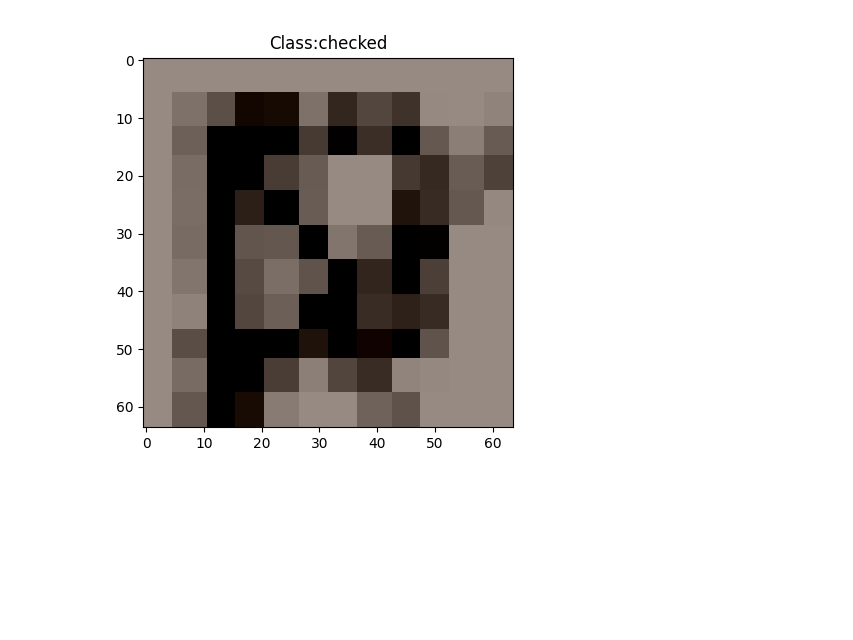

Press 1 to continue, 0 to break : 0
0


In [ ]:
fig, ax = plt.subplots()
class_dict = {'0':'checked', '1': 'not-checkbox', '2': 'open'}
outer_loop_break_flag = False
for x_batch, y_batch in train_data_gen:
    if not outer_loop_break_flag:
        for i in range (0,batch_size):
            plt.ion()
            image = np.clip(x_batch[i],0,1)
            plt.title('Class:' + class_dict[str(np.argmax(y_batch[i]))])
            ax.imshow(image)
            plt.gcf().canvas.draw()
            yorn = input("Press 1 to continue, 0 to break : ") 
            print(yorn)
            if yorn == '0':
                outer_loop_break_flag = True
                break

## Step 2 a: Model 1: Vanilla Convnet - up to 70-75% accuracy on a limited validation set.

In order to run this step make sure that `model_1 = True` in Step 1 above.

This step runs the vanilla convnet which has two convolutional layers with max-pooling followed by a dense layer with softmax. Given the small amount of data a simple classifier often is a good first place to start in order to be able to see what classes get confused the most and so on. The model was tweaked a little bit by looking at the performance of the model on the validation set. For example a batch size of 16 seemed to make a performance hit, vs trying kernel sizes of (3,3) vs (5,5). A kernel size of (5,5) was finally chosen for performance reasons. Dropout seemed to make a difference in the final dense layer and a value of 0.5 seemed to be better than 0.25. Furthermore, a callback function was written to save the weights locally depending on the model that gave the best validation performance over 50 epochs. In addition I initially tried two dense layers vs the one that is currently in the model. The validation performance was fairly poor since the model was overparameterized and was overfitting. I tried changing 'Adam' vs 'RMSProp' as well - Adam anecdotally seemed to perform better. One can see with this simple model and the validation accuracy numbers that one can reach perhaps an accuracy of 70-75% on this limited validation set.

In [6]:
if model_1:
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(img_height,img_width,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_filepath = 'weights_1'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    model.fit_generator(train_data_gen,
                        steps_per_epoch=step_size_train,
                        epochs=50,
                        validation_data=validation_data_gen,
                        callbacks=model_checkpoint_callback)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
17/17 [==============================] - 1s 53ms/step - loss: 1.0968 - accuracy: 0.4011 - val_loss: 1.0738 - val_accuracy: 0.4397
Epoch 2/50
17/17 [==============================] - 1s 40ms/step - loss: 1.0725 - accuracy: 0.4399 - val_loss: 1.0544 - val_accuracy: 0.4468
Epoch 3/50
17/17 [==============================] - 1s 38ms/step - loss: 1.0694 - accuracy: 0.4603 - val_loss: 1.0255 - val_accuracy: 0.5248
Epoch 4/50
17/17 [==============================] - 1s 36ms/step - loss: 1.0193 - accuracy: 0.4917 - val_loss: 0.9433 - val_accuracy: 0.6028
Epoch 5/50
17/17 [==============================] - 1s 38ms/step - loss: 0.9747 - accuracy: 0.5287 - val_loss: 0.9166 - val_accuracy: 0.5674
Epoch 6/50
17/17 [==============================] - 1s 37ms/step - loss: 0.9159 - accuracy: 0.5619 - val_loss: 0.9046 - val_accuracy: 0.5674
Epoch 7/50
17/17 [==============================] - 1s 38ms/step - loss: 0.934

## Model performance

Understanding model performance is often an important part of the workflow. While validation scores and training and validation error curves are great to look at to see if training is progressing correctly, it is often informative to look at a confusion matrix and metrics other than accuracy in especially detection problems and look at things like precision, recall and f1-score. For this exercise I often found through the use of the confusion matrix that my model was actually never really learning anything. For a bad training run where my model really wasn't really learning anything I found examples from all classes being classified as a single class. From the confusion matrix below on the validation set one can see that the model is at least learning "something", but more so see where the model is lacking. 

In [7]:
preds = model.predict_generator(validation_data_gen)
y_pred = np.argmax(preds, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_data_gen.classes, y_pred))
print('Classification Report')
target_names = ['checked', 'not-checkbox', 'open']
print(classification_report(validation_data_gen.classes, y_pred, target_names=target_names))

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[13 11 13]
 [10 13 19]
 [16 18 28]]
Classification Report
              precision    recall  f1-score   support

     checked       0.33      0.35      0.34        37
not-checkbox       0.31      0.31      0.31        42
        open       0.47      0.45      0.46        62

    accuracy                           0.38       141
   macro avg       0.37      0.37      0.37       141
weighted avg       0.38      0.38      0.38       141



## Step 2b : MobileNet - 60-65% on a limited validation set

In order to run this step make sure that `mobile_net = True` in Step 1 above.

One of the things (among many) that I learned while playing around with these pre-trained models was that the input image tensor size was fixed to a particular size. For example MobileNet has its (image_width, image_height) set to (224,224). This can often be an issue with low-resolution images such as the one provided for this exercise. As a result the input tensor often needs to be changed. There are multiple blog posts which talk about this issue, such as https://www.pyimagesearch.com/2019/06/24/change-input-shape-dimensions-for-fine-tuning-with-keras/.  What appears below is a `change_model` function that was taken from [this](https://medium.com/@ckyrkou/changing-input-size-of-pre-trained-models-in-keras-3dfbe3ca3091) blog-post. As mentioned earlier, this model does not give the best validation set performance. One reason could be models of this class that use BatchNorm could be remebering statistics of the original dataset instead. Furthermore, checking the accuracy of the input tensor, and the weights that are finally loaded and convolved need to be checked.

In [15]:
def change_model(model, new_input_shape=(None, img_width, img_height, 3)):
    # replace input shape of first layer
    model._layers[0].batch_input_shape = new_input_shape

    # rebuild model architecture by exporting and importing via json
    new_model = keras.models.model_from_json(model.to_json())

    # copy weights from old model to new one
    for layer in new_model.layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
            print("Loaded layer {}".format(layer.name))
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

    return new_model

if mobile_net:
    from keras.applications import MobileNet
    from keras.layers import Dense
    from keras.models import Model
    base_model = MobileNet(weights='imagenet',
                           include_top=False)

    base_model_changed = change_model(base_model)
    x=base_model_changed.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(512,activation='relu')(x) #dense layer 3
    preds=Dense(num_classes,activation='softmax')(x) #final layer with softmax activation
    model=Model(base_model_changed.input, preds)
    for layer in model.layers[:80]:
        layer.trainable = False
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(train_data_gen,
                        steps_per_epoch=step_size_train,
                        epochs=50,
                        validation_data=validation_data_gen)


Loaded layer input_4
Loaded layer conv1_pad
Loaded layer conv1
Loaded layer conv1_bn
Loaded layer conv1_relu
Loaded layer conv_dw_1
Loaded layer conv_dw_1_bn
Loaded layer conv_dw_1_relu
Loaded layer conv_pw_1
Loaded layer conv_pw_1_bn
Loaded layer conv_pw_1_relu
Loaded layer conv_pad_2
Loaded layer conv_dw_2
Loaded layer conv_dw_2_bn
Loaded layer conv_dw_2_relu
Loaded layer conv_pw_2
Loaded layer conv_pw_2_bn
Loaded layer conv_pw_2_relu
Loaded layer conv_dw_3
Loaded layer conv_dw_3_bn
Loaded layer conv_dw_3_relu
Loaded layer conv_pw_3
Loaded layer conv_pw_3_bn
Loaded layer conv_pw_3_relu
Loaded layer conv_pad_4
Loaded layer conv_dw_4
Loaded layer conv_dw_4_bn
Loaded layer conv_dw_4_relu
Loaded layer conv_pw_4
Loaded layer conv_pw_4_bn
Loaded layer conv_pw_4_relu
Loaded layer conv_dw_5
Loaded layer conv_dw_5_bn
Loaded layer conv_dw_5_relu
Loaded layer conv_pw_5
Loaded layer conv_pw_5_bn
Loaded layer conv_pw_5_relu
Loaded layer conv_pad_6
Loaded layer conv_dw_6
Loaded layer conv_dw_6_bn


## Step 2c : VGGNet16 - 70-75% out of the box

Make sure that in Step 1 `vgg_net = True`

As mentioned in [this tutorial](https://riptutorial.com/keras/example/32608/transfer-learning-using-keras-and-vgg) loading the VGGNet model supports an argument for the input_tensor. Therefore one did not need to include a `change_model` function as a part of the implementation.

In [22]:
if vgg_net:
    from keras.layers import Input
    from keras import applications
    from keras.models import Model
    input_tensor = Input(shape=(img_height, img_width, 3))
    vgg_model = applications.VGG16(weights='imagenet',
                                   include_top=False,
                                   input_tensor=input_tensor)
    # Creating dictionary that maps layer names to the layers
    layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

    # Getting output tensor of the last VGG layer that we want to include
    x = layer_dict['block2_pool'].output

    # Stacking a new simple convolutional network on top of it
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    custom_model = Model(vgg_model.input, x)
    # Make sure that the pre-trained bottom layers are not trainable
    for layer in custom_model.layers[:7]:
        layer.trainable = False

    # Do not forget to compile it
    custom_model.compile(loss='categorical_crossentropy',
                         optimizer='Adam',
                         metrics=['accuracy'])
    custom_model.fit_generator(train_data_gen,
                        steps_per_epoch=step_size_train,
                        epochs=50,
                        validation_data=validation_data_gen)

Epoch 1/50
17/17 [==============================] - 2s 89ms/step - loss: 12.0398 - accuracy: 0.3641 - val_loss: 1.3680 - val_accuracy: 0.5177
Epoch 2/50
17/17 [==============================] - 1s 72ms/step - loss: 1.2059 - accuracy: 0.5102 - val_loss: 0.9133 - val_accuracy: 0.5674
Epoch 3/50
17/17 [==============================] - 1s 75ms/step - loss: 0.8949 - accuracy: 0.5915 - val_loss: 0.8853 - val_accuracy: 0.6028
Epoch 4/50
17/17 [==============================] - 1s 78ms/step - loss: 0.6713 - accuracy: 0.7098 - val_loss: 0.8062 - val_accuracy: 0.6241
Epoch 5/50
17/17 [==============================] - 1s 78ms/step - loss: 0.5487 - accuracy: 0.7726 - val_loss: 0.9274 - val_accuracy: 0.6170
Epoch 6/50
17/17 [==============================] - 1s 80ms/step - loss: 0.5078 - accuracy: 0.8004 - val_loss: 0.7396 - val_accuracy: 0.6738
Epoch 7/50
17/17 [==============================] - 1s 84ms/step - loss: 0.4605 - accuracy: 0.8373 - val_loss: 0.7577 - val_accuracy: 0.7163
Epoch 8/50
1